# 1. Import of TXT dataset to variables

In [678]:
!git clone https://github.com/ehlymana/CEGSet.git

fatal: destination path 'CEGSet' already exists and is not an empty directory.


In [679]:
import os

path = "/content/CEGSet/ETF-RI-CEG Specifications"
graphs = []

files = os.listdir(path)
for file in files:
  graphs.append(open(path + '/' + file).read())

print("Example graph in TXT format:\n")
print(graphs[0])

Example graph in TXT format:

CAUSES:
C,1,63,29
C,2,64,98
C,3,61,157
C,4,60,216
C,5,57,274
C,6,58,330
C,7,58,385
C,8,61,446
C,9,61,507
EFFECTS:
E,1,723,273
INTERMEDIATES:
I,1,180,135
I,2,316,110
I,3,211,283
I,4,434,184
I,5,547,242
I,6,242,449
RELATION:
AND
CAUSE:
C,2,64,98
CAUSE:
C,3,61,157
EFFECT:
I,1,180,135
RELATION:
AND
CAUSE:
I,2,316,110
CAUSE:
I,3,211,283
EFFECT:
I,4,434,184
RELATION:
OR
CAUSE:
C,1,63,29
CAUSE:
C,4,60,216
CAUSE:
C,5,57,274
CAUSE:
I,1,180,135
EFFECT:
I,2,316,110
RELATION:
OR
CAUSE:
C,4,60,216
CAUSE:
C,5,57,274
CAUSE:
C,6,58,330
CAUSE:
C,7,58,385
EFFECT:
I,3,211,283
RELATION:
OR
CAUSE:
I,4,434,184
CAUSE:
I,3,211,283
EFFECT:
I,5,547,242
RELATION:
OR
CAUSE:
C,8,61,446
CAUSE:
C,9,61,507
EFFECT:
I,6,242,449
RELATION:
OR
CAUSE:
I,5,547,242
CAUSE:
I,6,242,449
EFFECT:
E,1,723,273



# 2. Conversion to the Boolean features format

In [680]:
def relation_to_row(relation, n_causes, n_effects, n_intermediates):
  row = [0] * (n_causes + n_intermediates + n_effects)

  relation_name = relation.split("\n")[0]
  if relation_name in ["DIR", "NOT", "AND", "OR", "NAND", "NOR"]:
    relation_type = "Y"
  else:
    relation_type = "N"

  if relation_name != "MSK":
    causes = relation.split("\nCAUSE:\n")
    causes.pop(0)
    causes[len(causes) - 1] = causes[len(causes) - 1].split("\nEFFECT:\n")[0]

    for node in causes:
      node = node.split(",")
      node_type = node[0]
      node_number = int(node[1])
      index = 0
      if node_type == "I":
        index += n_causes
      elif node_type == "E":
        index += n_causes + n_intermediates

      if relation_name == "REQ" and node == causes[len(causes) - 1]:
        row[index + node_number - 1] = 2
      else:
        row[index + node_number - 1] = 1

  if relation_name not in ["EXC", "INC", "EXCINC", "REQ"]:
    effects = relation.split("\nEFFECT:\n")
    effects.pop(0)
    for effect in effects:
      effect = effect.split(",")
      node_type = effect[0]
      node_number = int(effect[1])
      index = n_causes
      if node_type == "E":
        index += n_intermediates
      if relation_name != "MSK":
        row[index + node_number - 1] = 2
      else:
        row[index + node_number - 1] = 1

  dataset_row = []
  dataset_row.append(relation_type)
  dataset_row.append(relation_name)
  for node in row:
    dataset_row.append(node)

  return dataset_row

In [681]:
def graph_to_features(index, graph, n_causes, n_effects, n_intermediates, class_variable):
  rows = []
  all_relations = graph.split("\nRELATION:\n")
  all_relations.pop(0)
  for relation in all_relations:
    row = relation_to_row(relation, n_causes, n_effects, n_intermediates)
    row.insert(0, index)
    row.append(class_variable)
    rows.append(row)

  return rows

In [682]:
def calculate_node_numbers(graph):
  causes = graph.split("\nEFFECTS:\n")[0]
  effects = graph.split("\nINTERMEDIATES:\n")[0].split("\nEFFECTS:\n")[1]
  intermediates = graph.split("\nRELATION:\n")[0].split("\nINTERMEDIATES:\n")
  if len(intermediates) > 1:
     intermediates = intermediates[1]
     no_intermediates = len(intermediates.split("\n"))
  else:
    no_intermediates = 0

  no_causes = len(causes.split("\n")) - 1
  no_effects = len(effects.split("\n"))

  return no_causes, no_effects, no_intermediates

In [683]:
max_causes = 0
max_effects = 0
max_intermediates = 0

for graph in graphs:
  no_causes, no_effects, no_intermediates = calculate_node_numbers(graph)

  if no_causes > max_causes:
    max_causes = no_causes
  if no_effects > max_effects:
    max_effects = no_effects
  if no_intermediates > max_intermediates:
    max_intermediates = no_intermediates

print([max_causes, max_effects, max_intermediates])

[19, 14, 14]


In [684]:
list_boolean = []

index = 1
for graph in graphs:
  rows = graph_to_features(index, graph, max_causes, max_effects, max_intermediates, "Feasible")
  for row in rows:
    list_boolean.append(row)
  index += 1

print(list_boolean[0])

[1, 'Y', 'AND', 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Feasible']


In [685]:
import pandas as pd

column_names = ["Index", "Relation type", "Relation name"]
for i in range(0, max_causes):
  column_names.append("C" + str(i + 1))

for i in range(0, max_intermediates):
  column_names.append("I" + str(i + 1))

for i in range(0, max_effects):
  column_names.append("E" + str(i + 1))

column_names.append("Outcome")

dataset_boolean_feasible = pd.DataFrame(list_boolean, columns = column_names)
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 25)
dataset_boolean_feasible

,Index,Relation type,Relation name,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,Outcome
0,1,Y,AND,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Feasible
1,1,Y,AND,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,65,N,MSK,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,Feasible
572,65,N,MSK,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,Feasible


# 3. Conversion to the TF-IDF graph format

In [686]:
def relation_to_word(relation):
  relation_name = relation.split("\n")[0]
  relation_causes = []
  relation_effects = []

  if relation_name != "MSK":
    causes = relation.split("\nCAUSE:\n")
    causes.pop(0)
    causes[len(causes) - 1] = causes[len(causes) - 1].split("\nEFFECT:\n")[0]

    for node in causes:
      node = node.split(",")
      node_type = node[0]
      node_number = node[1]
      relation_causes.append(node[0] + node[1])

    relation_causes.sort()

  if relation_name not in ["EXC", "INC", "EXCINC", "REQ"]:
    effects = relation.split("\nEFFECT:\n")
    effects.pop(0)
    for effect in effects:
      effect = effect.split(",")
      relation_effects.append(effect[0] + effect[1])

  word = relation_name + " ("
  for cause in relation_causes:
    word += cause + ","
  if word[len(word) - 1] == ",":
    word = word[0 : len(word) - 1]
  word += ")"

  if len(relation_effects) > 0:
    word += " = "
    for effect in relation_effects:
      word += effect + ","
    word = word[0 : len(word) - 1]

  return word

In [687]:
def graph_to_words(graph):
  words = []
  all_relations = graph.split("\nRELATION:\n")
  all_relations.pop(0)
  for relation in all_relations:
    word = relation_to_word(relation)
    words.append(word)

  return words

In [688]:
import numpy as np

data_words = []
relation_vector = []
repetitions = []

i = 0
for graph in graphs:
  words = graph_to_words(graph)
  for word in words:
    if word not in relation_vector:
      relation_vector.append(word)
      repetitions.append(1)
    else:
      index = relation_vector.index(word)
      repetitions[index] += 1

for i in range(0, len(relation_vector)):
  data_words.append([i + 1, relation_vector[i], repetitions[i]])

words_vector = pd.DataFrame(data_words, columns = ["Number", "Word", "Repetitions"])
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 20)
words_vector

,Number,Word,Repetitions
0,1,"AND (C2,C3) = I1",3
1,2,"AND (I2,I3) = I4",1
2,3,"OR (C1,C4,C5,I1) = I2",1
...,...,...,...
393,394,"NAND (C2,C3) = E2",1
394,395,"AND (C1,I1) = E3",1
395,396,DIR (C4) = E4,1


In [689]:
def graph_to_1H_vector(graph, words_vector, feasibility):
  one_hot_vector = [0] * len(words_vector)
  words = graph_to_words(graph)

  for word in words:
    index = np.where(words_vector["Word"] == word)[0][0]
    one_hot_vector[index] = words_vector.loc[index]["Repetitions"]

  one_hot_vector.append(feasibility)

  return one_hot_vector

In [690]:
one_hot_vectors = []

for graph in graphs:
  one_hot_vector = graph_to_1H_vector(graph, words_vector, "Feasible")
  one_hot_vectors.append(one_hot_vector)

one_hot_vectors = pd.DataFrame(one_hot_vectors)
one_hot_vectors

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
0,3,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Feasible
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Feasible
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Feasible
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Feasible
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Feasible


In [691]:
import math

def graph_to_TFIDF_vector(graph, words_vector, feasibility):
  tf_idf_vector = [0] * len(words_vector)
  words = graph_to_words(graph)

  for word in words:
    index = np.where(words_vector["Word"] == word)[0][0]
    repetition = words_vector.loc[index]["Repetitions"]
    tf = 1 / len(words)
    idf = math.log(len(words_vector) / repetition, 2)

    tf_idf_vector[index] = tf * idf

  tf_idf_vector.append(feasibility)

  return tf_idf_vector

In [692]:
tf_idf_vectors = []

for graph in graphs:
  tf_idf_vector = graph_to_TFIDF_vector(graph, words_vector, "Feasible")
  tf_idf_vectors.append(tf_idf_vector)

tf_idf_vectors = pd.DataFrame(tf_idf_vectors)
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 20)
tf_idf_vectors

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
0,1.006342,1.232765,1.232765,1.232765,1.232765,1.232765,1.232765,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,Feasible
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.314678,4.314678,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.157339,0.000000,Feasible
64,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.232765,Feasible


# 4. Undersampling

## a) Boolean features

In [693]:
import random

def get_random_relation(index, no_causes, no_effects, no_intermediates, class_variable):
  relations = ["DIR", "NOT", "AND", "OR", "NAND", "NOR", "EXC", "INC", "EXCINC", "REQ", "MSK"]
  relation_name = relations[random.randint(0, len(relations) - 1)]
  if relation_name in relations[0 : 6]:
    relation_type = "Y"
  else:
    relation_type = "N"

  row = [0] * (no_causes + no_intermediates + no_effects)

  number_of_nodes = random.randint(0, (no_causes + no_effects + no_intermediates - 1))
  for i in range(0, number_of_nodes):
    node = random.randint(0, (no_causes + no_effects + no_intermediates - 1))
    direction = random.randint(0, 1)
    row[node] = direction

  if relation_name != "MSK":
    effect = random.randint(0, (no_causes + no_effects + no_intermediates - 1))
    row[effect] = 2

  else:
    for i in range(0, random.randint(0, (no_effects))):
      effect = random.randint(0, (no_causes + no_effects + no_intermediates - 1))
      row[effect] = 1

  row.insert(0, relation_name)
  row.insert(0, relation_type)
  row.insert(0, index)
  row.append(class_variable)

  return row

In [694]:
list_boolean = []

max_relations = 0
for i in range(0, len(graphs)):
  relations = len(dataset_boolean_feasible[dataset_boolean_feasible["Index"] == i + 1])
  if relations > max_relations:
    max_relations = relations

for i in range(0, len(graphs)):
  relations = random.randint(1, max_relations - 1)
  for j in range(0, relations):
    relation = get_random_relation(i + 1 + len(graphs), max_causes, max_effects, max_intermediates, "Infeasible")
    list_boolean.append(relation)

    if len(list_boolean) == len(dataset_boolean_feasible):
      break

  else:
    continue
  break

print(list_boolean[0])

[66, 'Y', 'OR', 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 'Infeasible']


In [695]:
column_names = ["Index", "Relation type", "Relation name"]
for i in range(0, max_causes):
  column_names.append("C" + str(i + 1))

for i in range(0, max_intermediates):
  column_names.append("I" + str(i + 1))

for i in range(0, max_effects):
  column_names.append("E" + str(i + 1))

column_names.append("Outcome")

dataset_boolean_infeasible = pd.DataFrame(list_boolean, columns = column_names)
dataset_boolean_infeasible

,Index,Relation type,Relation name,C1,C2,C3,C4,C5,C6,C7,...,E6,E7,E8,E9,E10,E11,E12,E13,E14,Outcome
0,66,Y,OR,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,Infeasible
1,66,N,MSK,1,1,0,0,0,0,1,...,1,1,0,1,1,0,0,0,0,Infeasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,87,N,INC,0,1,0,0,0,0,0,...,0,0,2,1,0,0,0,1,0,Infeasible
572,87,N,EXC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,Infeasible


In [696]:
dataset_boolean = pd.concat([dataset_boolean_feasible, dataset_boolean_infeasible])
print("Final form of dataset: " + str(dataset_boolean.shape))

Final form of dataset: (1146, 51)


In [697]:
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 25)
dataset_boolean

,Index,Relation type,Relation name,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,Outcome
0,1,Y,AND,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Feasible
1,1,Y,AND,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,87,N,INC,0,1,0,0,0,0,0,0,0,...,0,1,0,0,2,1,0,0,0,1,0,Infeasible
572,87,N,EXC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0,0,Infeasible


In [698]:
dataset_boolean.to_csv("dataset_boolean.csv", index = False)

## b) TF-IDF graph

In [699]:
def array_relation_to_word(relation, no_causes, no_effects, no_intermediates):
  relation_name = relation[2]
  relation_causes = []
  relation_effects = []

  for i in range(3, len(relation) - 1):
    node_type = "C"
    index = i - 2
    if i >= no_causes + 2 and i < no_causes + no_intermediates + 2:
      node_type = "I"
      index = i - 1 - no_causes
    elif i >= no_causes + no_intermediates + 2:
      node_type = "E"
      index = i - 1 - no_causes - no_intermediates

    if relation[i] == 2:
      relation_effects.append(node_type + str(index))
    elif relation[i] == 1:
      relation_causes.append(node_type + str(index))

  relation_causes.sort()

  word = relation_name + " ("
  for cause in relation_causes:
    word += cause + ","
  if word[len(word) - 1] == ",":
    word = word[0 : len(word) - 1]
  word += ")"

  if len(relation_effects) > 0:
    word += " = "
    for effect in relation_effects:
      word += effect + ","
    word = word[0 : len(word) - 1]

  return word

In [700]:
data_words = []
relation_vector = []
repetitions = []

i = 0
for graph in graphs:
  words = graph_to_words(graph)
  for word in words:
    if word not in relation_vector:
      relation_vector.append(word)
      repetitions.append(1)
    else:
      index = relation_vector.index(word)
      repetitions[index] += 1

for relation in list_boolean:
  word = array_relation_to_word(relation, max_causes, max_effects, max_intermediates)
  if word not in relation_vector:
    relation_vector.append(word)
    repetitions.append(1)
  else:
    index = relation_vector.index(word)
    repetitions[index] += 1

for i in range(0, len(relation_vector)):
  data_words.append([i + 1, relation_vector[i], repetitions[i]])

words_vector = pd.DataFrame(data_words, columns = ["Number", "Word", "Repetitions"])
pd.set_option("display.max_rows", 6)
pd.set_option("display.max_columns", 20)
words_vector

,Number,Word,Repetitions
0,1,"AND (C2,C3) = I1",3
1,2,"AND (I2,I3) = I4",1
2,3,"OR (C1,C4,C5,I1) = I2",1
...,...,...,...
966,967,"EXCINC (C13,C14,E11,I2,I4,I6,I9) = E7",1
967,968,"INC (C13,C2,E10,E14,E6,I12,I7,I8) = E9",1
968,969,EXC (I7) = E13,1


In [701]:
def array_to_1H_vector(sublist, words_vector, feasibility):
  one_hot_vector = [0] * len(words_vector)
  words = []
  for relation in sublist:
    words.append(array_relation_to_word(relation, max_causes, max_effects, max_intermediates))

  for word in words:
    index = np.where(words_vector["Word"] == word)[0][0]
    one_hot_vector[index] = words_vector.loc[index]["Repetitions"]

  one_hot_vector.append(feasibility)

  return one_hot_vector

In [702]:
one_hot_vectors = []

for graph in graphs:
  one_hot_vector = graph_to_1H_vector(graph, words_vector, "Feasible")
  one_hot_vectors.append(one_hot_vector)

index = len(graphs) + 1
i = 0
while i < len(list_boolean):
  sublist = []
  while i < len(list_boolean) and list_boolean[i][0] == index:
    sublist.append(list_boolean[i])
    i += 1
  index += 1

  one_hot_vector = array_to_1H_vector(sublist, words_vector, "Infeasible")
  one_hot_vectors.append(one_hot_vector)

one_hot_vectors = pd.DataFrame(one_hot_vectors)
one_hot_vectors

,0,1,2,3,4,5,6,7,8,9,...,960,961,962,963,964,965,966,967,968,969
0,3,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Feasible
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Feasible
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Infeasible
85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Infeasible
86,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,Infeasible


In [703]:
def array_to_TFIDF_vector(sublist, words_vector, feasibility):
  tf_idf_vector = [0] * len(words_vector)
  words = []
  for relation in sublist:
    words.append(array_relation_to_word(relation, max_causes, max_effects, max_intermediates))

  for word in words:
    index = np.where(words_vector["Word"] == word)[0][0]
    repetition = words_vector.loc[index]["Repetitions"]
    tf = 1 / len(words)
    idf = math.log(len(words_vector) / repetition, 2)

    tf_idf_vector[index] = tf * idf

  tf_idf_vector.append(feasibility)

  return tf_idf_vector

In [704]:
tf_idf_vectors = []

for graph in graphs:
  tf_idf_vector = graph_to_TFIDF_vector(graph, words_vector, "Feasible")
  tf_idf_vectors.append(tf_idf_vector)

index = len(graphs) + 1
i = 0
while i < len(list_boolean):
  sublist = []
  while i < len(list_boolean) and list_boolean[i][0] == index:
    sublist.append(list_boolean[i])
    i += 1
  index += 1

  tf_idf_vector = array_to_TFIDF_vector(sublist, words_vector, "Infeasible")
  tf_idf_vectors.append(tf_idf_vector)

tf_idf_vectors = pd.DataFrame(tf_idf_vectors)
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 15)
tf_idf_vectors

,0,1,2,3,4,5,6,...,963,964,965,966,967,968,969
0,1.19077,1.417193,1.417193,1.417193,1.417193,1.417193,1.417193,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Feasible
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Infeasible
86,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.90185,0.90185,0.90185,0.90185,0.90185,0.90185,Infeasible


In [705]:
print("Final form of dataset: " + str(tf_idf_vectors.shape))

Final form of dataset: (87, 970)


In [706]:
words_vector.to_csv("words_vector.csv", index = False)

In [707]:
tf_idf_vectors.to_csv("tf_idf_vectors.csv", index = False)

# 5. Machine learning (Boolean features)

## Data import

In [708]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [709]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [710]:
##### you must change the path to your own Google Drive folder containing the dataset #####
path = "/content/drive/MyDrive/CEGSet/Dataset"
#path = "/content/drive/MyDrive/CEGSet (Damir)/Dataset"

dataset_boolean = pd.read_csv(path + "/dataset_boolean.csv")
tf_idf_vectors = pd.read_csv(path + "/tf_idf_vectors.csv")
words_vector = pd.read_csv(path + "/words_vector.csv")

In [711]:
dataset_boolean

,Index,Relation type,Relation name,C1,C2,C3,C4,...,E9,E10,E11,E12,E13,E14,Outcome
0,1,Y,AND,1,0,1,0,...,0,0,0,0,0,0,Feasible
1,1,Y,AND,0,1,0,1,...,0,0,0,0,0,0,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,90,Y,AND,0,0,0,0,...,0,0,1,0,0,0,Infeasible
1145,90,Y,AND,1,1,0,0,...,0,0,0,0,0,1,Infeasible


In [712]:
tf_idf_vectors

,0,1,2,3,4,5,6,...,963,964,965,966,967,968,969
0,0.708597,0.708597,0.708597,0.708597,0.708597,0.708597,0.708597,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Feasible
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Feasible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Infeasible
89,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.620022,0.620022,0.620022,0.620022,0.620022,0.620022,Infeasible


In [713]:
words_vector

,Number,Word,Repetitions
0,1,"AND (C1,C3) = I7",1
1,2,"AND (C2,C4) = I1",1
...,...,...,...
967,968,"AND (C10,C14,C15,C5,C9,E1,E12,E2,I10,I12,I3,I4...",1
968,969,"AND (C1,C10,C18,C2,C6,C8,E15,E7,I11,I13,I14,I3...",1


## 5.1. Function for calculating confusion matrix, accuracy, precision, recall and f1-score

In [714]:
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score
)


def calculate_metrics(model_name, tokenization_name, test_labels, predicted_labels):
    print(f"Results for {model_name} and {tokenization_name} are:")
    print(f"\tConfusion matrix: \n{confusion_matrix(test_labels, predicted_labels)}")
    print(f"\tAccuracy: {accuracy_score(test_labels, predicted_labels)}")
    print(f"\tPrecision: {precision_score(test_labels, predicted_labels)}")
    print(f"\tRecall: {recall_score(test_labels, predicted_labels)}")
    print(f"\tF1-score: {f1_score(test_labels, predicted_labels)}")

    return [model_name + " " + tokenization_name,
            accuracy_score(test_labels, predicted_labels),
            precision_score(test_labels, predicted_labels),
            recall_score(test_labels, predicted_labels),
            f1_score(test_labels, predicted_labels)]

## 5.2. Training and test split (Boolean)

In [715]:
# Encoding categorical variables into integers
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical column
dataset_boolean['Relation name'] = label_encoder.fit_transform(dataset_boolean['Relation name'])
dataset_boolean['Relation type'] = label_encoder.fit_transform(dataset_boolean['Relation type'])

In [716]:
from sklearn.model_selection import train_test_split

# Convert dataframe into 2D array
# Split columns into X (all except "Outcome" column) and y (just "Outcome" column)
X_boolean = dataset_boolean.drop('Outcome', axis=1).values
y_boolean = dataset_boolean['Outcome'].replace({"Feasible": 1, "Infeasible": 0})

# Replace two classes in "Outcome" column into integers
y_boolean = y_boolean.values

X_train_boolean, X_test_boolean, y_train_boolean, y_test_boolean = train_test_split(X_boolean, y_boolean, test_size=0.2, shuffle=True, random_state=42)

results = []

## 5.3. Naive Bayes (Boolean)

In [717]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Create and train the Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_boolean, y_train_boolean)

# Predict the labels for the test set
nb_boolean_y_pred = classifier.predict(X_test_boolean)

results.append(calculate_metrics("Naive Bayes", "Boolean", y_test_boolean, nb_boolean_y_pred))

Results for Naive Bayes and Boolean are:
	Confusion matrix: 
[[ 96   7]
 [ 17 110]]
	Accuracy: 0.8956521739130435
	Precision: 0.9401709401709402
	Recall: 0.8661417322834646
	F1-score: 0.9016393442622952


## 5.4. SVM (Boolean)

In [718]:
from sklearn import svm

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel="linear", degree=3, gamma="auto")
SVM.fit(X_train_boolean, y_train_boolean)
# predict the labels on validation dataset
svm_boolean_y_pred = SVM.predict(X_test_boolean)

results.append(calculate_metrics("SVM", "Boolean", y_test_boolean, svm_boolean_y_pred))

Results for SVM and Boolean are:
	Confusion matrix: 
[[103   0]
 [  0 127]]
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0


## 5.5. XGBoost (Boolean)

In [719]:
import xgboost as xgb

# Create and train the XGBoost classifier
xgboost_classifier = xgb.XGBClassifier()
xgboost_classifier.fit(X_train_boolean, y_train_boolean)

# Predict the labels for the test set
xgboost_boolean_y_pred = xgboost_classifier.predict(X_test_boolean)

results.append(calculate_metrics("XGBoost", "Boolean", y_test_boolean, xgboost_boolean_y_pred))

Results for XGBoost and Boolean are:
	Confusion matrix: 
[[103   0]
 [  0 127]]
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0


## 5.6. Random forest (Boolean)

In [720]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_boolean, y_train_boolean)

# Make predictions on the test data
rf_boolean_y_pred = rf_classifier.predict(X_test_boolean)

results.append(calculate_metrics("Random forest", "Boolean", y_test_boolean, rf_boolean_y_pred))

Results for Random forest and Boolean are:
	Confusion matrix: 
[[103   0]
 [  0 127]]
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0


## 5.7. AdaBoost (Boolean)

In [721]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an AdaBoost classifier with Decision Tree as base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Fit the classifier to the training data
adaboost_classifier.fit(X_train_boolean, y_train_boolean)

# Make predictions on the test data
adaboost_boolean_y_pred = adaboost_classifier.predict(X_test_boolean)

results.append(calculate_metrics("AdaBoost", "Boolean", y_test_boolean, adaboost_boolean_y_pred))

Results for AdaBoost and Boolean are:
	Confusion matrix: 
[[103   0]
 [  0 127]]
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


## 5.8. Voting ensemble (Boolean)

In [722]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create individual classifiers
#ensemble_classifier_1 = LogisticRegression(random_state=42)
ensemble_classifier_1 = MultinomialNB()
#ensemble_classifier_2 = DecisionTreeClassifier(random_state=42)
ensemble_classifier_2 = svm.SVC(C=1.0, kernel="linear", degree=3, gamma="auto")
#ensemble_classifier_3 = SVC(random_state=42)
#base_estimator = DecisionTreeClassifier(max_depth=1)
ensemble_classifier_3 = LogisticRegression()

# Create an ensemble using VotingClassifier
voting_ensemble_classifier = VotingClassifier(estimators=[('nb', ensemble_classifier_1), ('svm', ensemble_classifier_2), ('lr', ensemble_classifier_3)], voting='hard')

# Fit the ensemble to the training data
voting_ensemble_classifier.fit(X_train_boolean, y_train_boolean)

# Make predictions on the test data
voting_ensemble_boolean_y_pred = voting_ensemble_classifier.predict(X_test_boolean)

results.append(calculate_metrics("Voting ensemble", "Boolean", y_test_boolean, voting_ensemble_boolean_y_pred))

Results for Voting ensemble and Boolean are:
	Confusion matrix: 
[[103   0]
 [  0 127]]
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5.9. Logistic regression (Boolean)

In [723]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression classifier
logreg_classifier = LogisticRegression()

# Fit the classifier to the training data
logreg_classifier.fit(X_train_boolean, y_train_boolean)

# Make predictions on the test data
logreg_boolean_y_pred = logreg_classifier.predict(X_test_boolean)

results.append(calculate_metrics("Logistic regression", "Boolean", y_test_boolean, logreg_boolean_y_pred))

Results for Logistic regression and Boolean are:
	Confusion matrix: 
[[102   1]
 [  1 126]]
	Accuracy: 0.991304347826087
	Precision: 0.9921259842519685
	Recall: 0.9921259842519685
	F1-score: 0.9921259842519685


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5.10. LSTM (Boolean)

In [724]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

import matplotlib.pyplot as plt

# Reshape the input data to match LSTM input shape (samples, timesteps, features)
LSTM_X_train = np.reshape(X_train_boolean, (X_train_boolean.shape[0], 1, X_train_boolean.shape[1]))
LSTM_X_test = np.reshape(X_test_boolean, (X_test_boolean.shape[0], 1, X_test_boolean.shape[1]))

# Split training data into training and validation
LSTM_X_train, LSTM_X_validation, LSTM_y_train, LSTM_y_validation = train_test_split(LSTM_X_train, y_train_boolean, test_size=0.2, shuffle=True, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, LSTM_X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# Train the model
#model.fit(LSTM_X_train, y_train_tf_idf, epochs=5, batch_size=1)
epochs = 50
history_boolean = model.fit(LSTM_X_train, LSTM_y_train, epochs=epochs, batch_size=1, validation_data=(LSTM_X_validation, LSTM_y_validation))

lstm_predictions = model.predict(LSTM_X_test)
lstm_predictions = np.round(lstm_predictions).flatten()

results.append(calculate_metrics("LSTM", "Boolean", y_test_boolean, lstm_predictions))

Epoch 1/50
732/732 [==============================] - 7s 7ms/step - loss: 0.2085 - accuracy: 0.9467 - val_loss: 0.1175 - val_accuracy: 0.9511
Epoch 2/50
732/732 [==============================] - 3s 3ms/step - loss: 0.0910 - accuracy: 0.9672 - val_loss: 0.0793 - val_accuracy: 0.9674
Epoch 3/50
732/732 [==============================] - 2s 3ms/step - loss: 0.0712 - accuracy: 0.9754 - val_loss: 0.0763 - val_accuracy: 0.9837
Epoch 4/50
732/732 [==============================] - 3s 3ms/step - loss: 0.0535 - accuracy: 0.9822 - val_loss: 0.1051 - val_accuracy: 0.9620
Epoch 5/50
732/732 [==============================] - 3s 4ms/step - loss: 0.0597 - accuracy: 0.9781 - val_loss: 0.0754 - val_accuracy: 0.9728
Epoch 6/50
732/732 [==============================] - 4s 5ms/step - loss: 0.0448 - accuracy: 0.9836 - val_loss: 0.0755 - val_accuracy: 0.9620
Epoch 7/50
732/732 [==============================] - 3s 4ms/step - loss: 0.0364 - accuracy: 0.9877 - val_loss: 0.1178 - val_accuracy: 0.9511
Epoch 

# 6. Machine learning (TF-IDF graph)

## 6.1. Training and test split (TF-IDF)

In [725]:
from sklearn.model_selection import train_test_split

# Convert dataframe into 2D array
# Split columns into X (all except "Outcome" column) and y (just "Outcome" column)
X_tf_idf = tf_idf_vectors[tf_idf_vectors.columns[:-1]].values

# Replace two classes in "Outcome" column into integers
y_tf_idf = tf_idf_vectors[tf_idf_vectors.columns[-1]].replace({"Feasible": 1, "Infeasible": 0})
y_tf_idf = y_tf_idf.values

X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(X_tf_idf, y_tf_idf, test_size=0.2, shuffle=True, random_state=42)

## 6.2. Naive Bayes (TF-IDF)

In [726]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Create and train the Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_tf_idf, y_train_tf_idf)

# Predict the labels for the test set
nb_tfidf_y_pred = classifier.predict(X_test_tf_idf)

results.append(calculate_metrics("Naive Bayes", "TF-IDF", y_test_tf_idf, nb_tfidf_y_pred))

Results for Naive Bayes and TF-IDF are:
	Confusion matrix: 
[[ 4  0]
 [ 2 12]]
	Accuracy: 0.8888888888888888
	Precision: 1.0
	Recall: 0.8571428571428571
	F1-score: 0.923076923076923


## 6.3. SVM (TF-IDF)

In [727]:
from sklearn import svm

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel="linear", degree=3, gamma="auto")
SVM.fit(X_train_tf_idf, y_train_tf_idf)
# predict the labels on validation dataset
svm_tfidf_y_pred = SVM.predict(X_test_tf_idf)

results.append(calculate_metrics("SVM", "TF-IDF", y_test_tf_idf, svm_tfidf_y_pred))

Results for SVM and TF-IDF are:
	Confusion matrix: 
[[ 4  0]
 [ 2 12]]
	Accuracy: 0.8888888888888888
	Precision: 1.0
	Recall: 0.8571428571428571
	F1-score: 0.923076923076923


## 6.4. XGBoost (TF-IDF)

In [728]:
import xgboost as xgb

# Create and train the XGBoost classifier
xgboost_classifier = xgb.XGBClassifier()
xgboost_classifier.fit(X_train_tf_idf, y_train_tf_idf)

# Predict the labels for the test set
xgboost_tfidf_y_pred = xgboost_classifier.predict(X_test_tf_idf)

results.append(calculate_metrics("XGBoost", "TF-IDF", y_test_tf_idf, xgboost_tfidf_y_pred))

Results for XGBoost and TF-IDF are:
	Confusion matrix: 
[[ 0  4]
 [ 0 14]]
	Accuracy: 0.7777777777777778
	Precision: 0.7777777777777778
	Recall: 1.0
	F1-score: 0.8750000000000001


## 6.5. Random forest (TF-IDF)

In [729]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_tf_idf, y_train_tf_idf)

# Make predictions on the test data
rf_tfidf_y_pred = rf_classifier.predict(X_test_tf_idf)

results.append(calculate_metrics("Random forest", "TF-IDF", y_test_tf_idf, rf_tfidf_y_pred))

Results for Random forest and TF-IDF are:
	Confusion matrix: 
[[ 0  4]
 [ 0 14]]
	Accuracy: 0.7777777777777778
	Precision: 0.7777777777777778
	Recall: 1.0
	F1-score: 0.8750000000000001


## 6.6. AdaBoost (TF-IDF)

In [730]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an AdaBoost classifier with Decision Tree as base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Fit the classifier to the training data
adaboost_classifier.fit(X_train_tf_idf, y_train_tf_idf)

# Make predictions on the test data
adaboost_tfidf_y_pred = adaboost_classifier.predict(X_test_tf_idf)

results.append(calculate_metrics("AdaBoost", "TF-IDF", y_test_tf_idf, adaboost_tfidf_y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Results for AdaBoost and TF-IDF are:
	Confusion matrix: 
[[4 0]
 [5 9]]
	Accuracy: 0.7222222222222222
	Precision: 1.0
	Recall: 0.6428571428571429
	F1-score: 0.782608695652174


## 6.7. Voting ensemble (TF-IDF)

In [731]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create individual classifiers
#ensemble_classifier_1 = LogisticRegression(random_state=42)
ensemble_classifier_1 = MultinomialNB()
#ensemble_classifier_2 = DecisionTreeClassifier(random_state=42)
ensemble_classifier_2 = svm.SVC(C=1.0, kernel="linear", degree=3, gamma="auto")
#ensemble_classifier_3 = SVC(random_state=42)
#base_estimator = DecisionTreeClassifier(max_depth=1)
ensemble_classifier_3 = LogisticRegression()

# Create an ensemble using VotingClassifier
voting_ensemble_classifier = VotingClassifier(estimators=[('nb', ensemble_classifier_1), ('svm', ensemble_classifier_2), ('lr', ensemble_classifier_3)], voting='hard')

# Fit the ensemble to the training data
voting_ensemble_classifier.fit(X_train_tf_idf, y_train_tf_idf)

# Make predictions on the test data
voting_ensemble_tfidf_y_pred = voting_ensemble_classifier.predict(X_test_tf_idf)

results.append(calculate_metrics("Voting ensemble", "TF-IDF", y_test_tf_idf, voting_ensemble_tfidf_y_pred))

Results for Voting ensemble and TF-IDF are:
	Confusion matrix: 
[[ 4  0]
 [ 2 12]]
	Accuracy: 0.8888888888888888
	Precision: 1.0
	Recall: 0.8571428571428571
	F1-score: 0.923076923076923


## 6.8. Logistic regression (TF-IDF)

In [732]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression classifier
logreg_classifier = LogisticRegression()

# Fit the classifier to the training data
logreg_classifier.fit(X_train_tf_idf, y_train_tf_idf)

# Make predictions on the test data
logreg_tfidf_y_pred = logreg_classifier.predict(X_test_tf_idf)

results.append(calculate_metrics("Logistic regression", "TF-IDF", y_test_tf_idf, logreg_tfidf_y_pred))

Results for Logistic regression and TF-IDF are:
	Confusion matrix: 
[[ 0  4]
 [ 0 14]]
	Accuracy: 0.7777777777777778
	Precision: 0.7777777777777778
	Recall: 1.0
	F1-score: 0.8750000000000001


## 6.9. LSTM (TF-IDF)

In [733]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

from keras.optimizers import RMSprop

# Reshape the input data to match LSTM input shape (samples, timesteps, features)
LSTM_X_train = np.reshape(X_train_tf_idf, (X_train_tf_idf.shape[0], 1, X_train_tf_idf.shape[1]))
LSTM_X_test = np.reshape(X_test_tf_idf, (X_test_tf_idf.shape[0], 1, X_test_tf_idf.shape[1]))

# Split training data into training and validation
LSTM_X_train, LSTM_X_validation, LSTM_y_train, LSTM_y_validation = train_test_split(LSTM_X_train, y_train_tf_idf, test_size=0.2, shuffle=True, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, LSTM_X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# Train the model
#model.fit(LSTM_X_train, y_train_tf_idf, epochs=5, batch_size=1)
epochs = 50
history_tfidf = model.fit(LSTM_X_train, LSTM_y_train, validation_data=(LSTM_X_validation, LSTM_y_validation), epochs=epochs, batch_size=1)

lstm_predictions = model.predict(LSTM_X_test)
lstm_predictions = np.round(lstm_predictions).flatten()

results.append(calculate_metrics("LSTM", "TF-IDF", y_test_tf_idf, lstm_predictions))

Epoch 1/50
57/57 [==============================] - 3s 19ms/step - loss: 0.6725 - accuracy: 0.5965 - val_loss: 0.6447 - val_accuracy: 0.8000
Epoch 2/50
57/57 [==============================] - 1s 10ms/step - loss: 0.5178 - accuracy: 1.0000 - val_loss: 0.5662 - val_accuracy: 0.8000
Epoch 3/50
57/57 [==============================] - 1s 9ms/step - loss: 0.3212 - accuracy: 1.0000 - val_loss: 0.4793 - val_accuracy: 0.8000
Epoch 4/50
57/57 [==============================] - 1s 10ms/step - loss: 0.1475 - accuracy: 1.0000 - val_loss: 0.4151 - val_accuracy: 0.8000
Epoch 5/50
57/57 [==============================] - 1s 9ms/step - loss: 0.0596 - accuracy: 1.0000 - val_loss: 0.3773 - val_accuracy: 0.8000
Epoch 6/50
57/57 [==============================] - 1s 10ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.3576 - val_accuracy: 0.8000
Epoch 7/50
57/57 [==============================] - 1s 9ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.3430 - val_accuracy: 0.8000
Epoch 8/50
57/57

# 7. Results visualization

<Figure size 640x480 with 0 Axes>

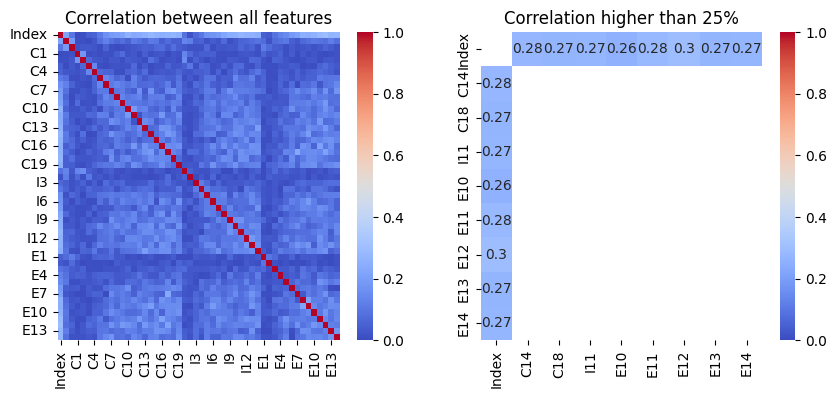

In [734]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dataset_boolean.corr(numeric_only = True).abs()
filtered_corr_matrix = corr_matrix[(corr_matrix >= .26) & (corr_matrix != 1.00)]
filtered_corr_matrix = filtered_corr_matrix.dropna(axis = 'rows', how = 'all')
filtered_corr_matrix = filtered_corr_matrix.dropna(axis = 'columns', how = 'all')

plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.heatmap(corr_matrix, cmap = 'coolwarm', ax = ax[0], vmin = 0, vmax = 1)
#annot = True, cbar_kws = {"shrink": 0.2},

#ax[0].set_xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
#ax[0].set_yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

ax[0].set_title("Correlation between all features")
ax[1].set_title("Correlation higher than 25%")

sns.heatmap(filtered_corr_matrix, cmap = "coolwarm", annot = True, ax = ax[1], vmin = 0, vmax = 1)

plt.show()

fig.savefig('pearson_correlation.png', bbox_inches = 'tight')

In [738]:
results_table = pd.DataFrame(results, columns = ["Model - Data format", "Accuracy", "Precision", "Recall", "F1 score"])

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
results_table

,Model - Data format,Accuracy,Precision,Recall,F1 score
0,Naive Bayes Boolean,0.895652,0.940171,0.866142,0.901639
1,SVM Boolean,1.000000,1.000000,1.000000,1.000000
2,XGBoost Boolean,1.000000,1.000000,1.000000,1.000000
3,Random forest Boolean,1.000000,1.000000,1.000000,1.000000
4,AdaBoost Boolean,1.000000,1.000000,1.000000,1.000000
5,Voting ensemble Boolean,1.000000,1.000000,1.000000,1.000000
6,Logistic regression Boolean,0.991304,0.992126,0.992126,0.992126
7,LSTM Boolean,0.960870,0.991667,0.937008,0.963563
8,Naive Bayes TF-IDF,0.888889,1.000000,0.857143,0.923077
9,SVM TF-IDF,0.888889,1.000000,0.857143,0.923077


<Figure size 640x480 with 0 Axes>

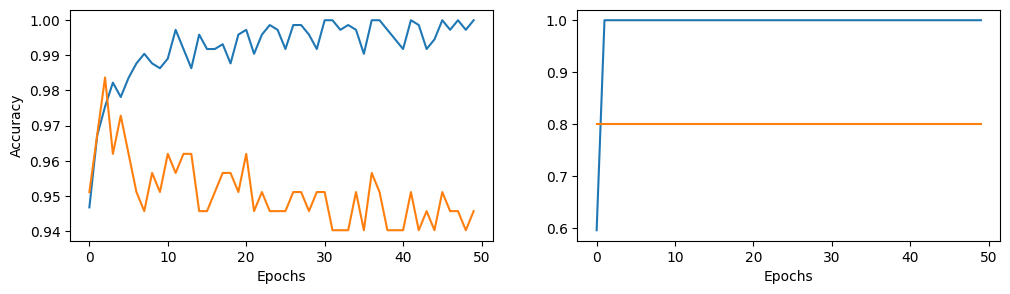

In [736]:
plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (12, 3))

ax[0].plot(range(epochs), history_boolean.history['accuracy'], label='Training Accuracy')
ax[0].plot(range(epochs), history_boolean.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(range(epochs), history_tfidf.history['accuracy'], label='Training Accuracy')
ax[1].plot(range(epochs), history_tfidf.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_xlabel('Epochs')

plt.show()
fig.savefig('lstm_accuracy.png', bbox_inches = 'tight')